# Analyze song features such as syllable entropy & entropy variance

In [2]:
# Import packages
import sys
sys.path.append(r"..")
from pyfinch.database.load import ProjectLoader
import matplotlib.pyplot as plt
from util.plot import plot_across_days_per_note, plot_bar_comparison
import seaborn as sns
import numpy as np
import pandas as pd
from pyfinch.utils import save
from pyfinch.utils.draw import remove_right_top
import warnings
warnings.filterwarnings('ignore')

# Parameters
nb_note_crit = 10

# Load song database
# csv_path = ProjectLoader().path / 'EntropySpkCorrNew' / 'ev new_window.csv'
db = ProjectLoader().load_db()
# # SQL statement
df = db.to_dataframe(
    f"""SELECT syl.*, song.taskSession, song.taskSessionDeafening, song.taskSessionPostDeafening, song.dph, song.block10days 
    FROM syllable syl INNER JOIN song ON syl.songID = song.id WHERE syl.nbNoteUndir >= {nb_note_crit}""")

ModuleNotFoundError: No module named 'pyfinch'

In [10]:
df['nbNoteUndir'].describe()
df['nbNoteUndir'].agg({'min', 'max', 'mean', 'median', 'std', 'sem', 'count'})

max       318.000000
sem         2.954417
median     44.000000
min        10.000000
count     331.000000
mean       64.471299
std        53.750898
Name: nbNoteUndir, dtype: float64

## Plot spectral entropy & entropy variance (ev) across days per bird per syllable

In [3]:
# Parameters
nb_row = 3
nb_col = 4
save_fig = False
fig_ext = '.png'
fr_crit = 0
feature = 'Spectral Entropy'  
save_path = save.make_dir(ProjectLoader().path / 'Analysis', 'Entropy', add_date=False)

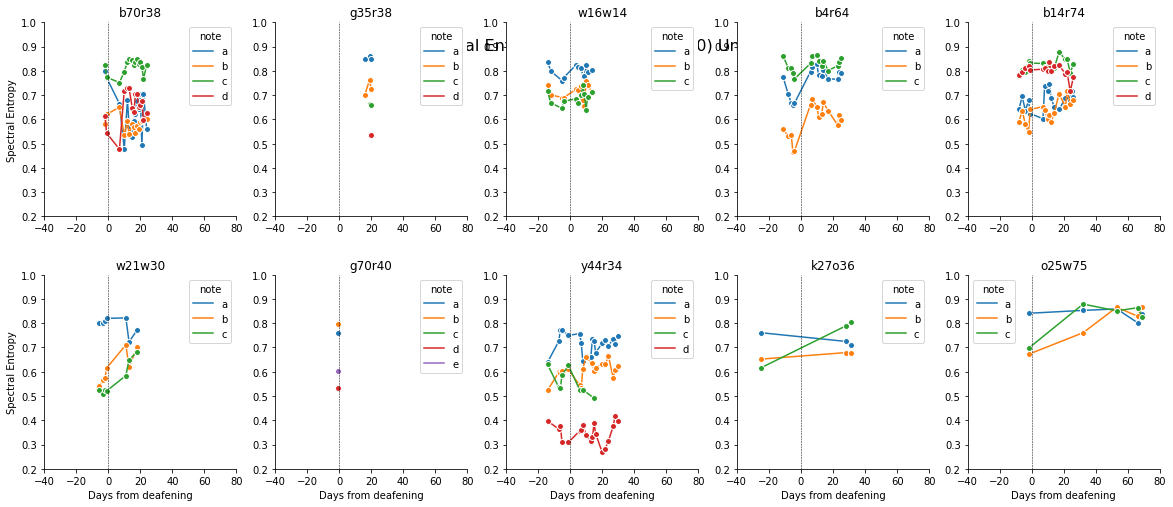

In [4]:
# Spectral Entropy
plot_across_days_per_note(df, x='taskSessionDeafening', y='entropyUndir',
                          x_label='Days from deafening',
                          y_label='Spectral Entropy',
                          title=f"Spectral Entropy (nb of notes >= {nb_note_crit}) Undir",
                          fig_name='Spectral_entropy_across_days',
                          x_lim=[-40, 80], y_lim=[0.2, 1],
                          vline=0,
                          view_folder=True,
                          save_fig=False,
                          save_path=save_path
                          )

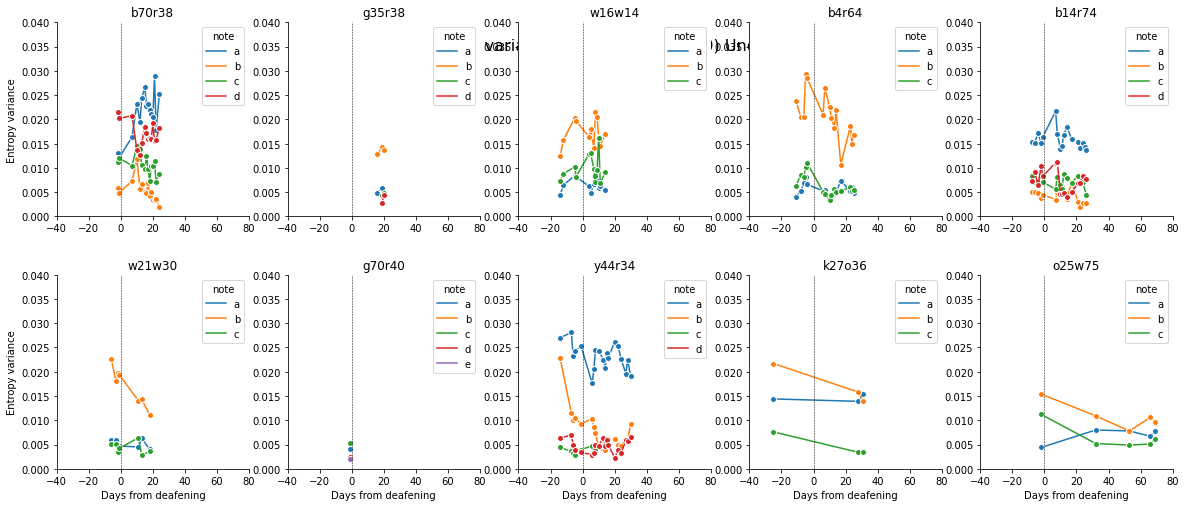

In [6]:
# Entropy variance
plot_across_days_per_note(df, x='taskSessionDeafening', y='entropyVarUndir',
                          x_label='Days from deafening',
                          y_label='Entropy variance',
                          title=f"Entropy variance (nb of notes >= {nb_note_crit}) Undir",
                          fig_name='EV_across_days',
                          x_lim=[-40, 80], y_lim=[0, 0.04],
                          vline=0,
                          view_folder=True,
                          save_fig=False,
                          save_path=save_path
                          )

## Plot normalized spectral entropy & entropy variance (ev) across days per bird per syllable

- Post-deafening songs normalized by division by pre-deafening mean

In [7]:
# Create a new column with normalized values
from pyfinch.analysis.functions import add_pre_normalized_col

df_norm = add_pre_normalized_col(df, 'entropyUndir', 'entropyUndirNorm')
df_norm = add_pre_normalized_col(df_norm, 'entropyDir', 'entropyDirNorm')

df_norm = add_pre_normalized_col(df_norm, 'entropyVarUndir', 'entropyVarUndirNorm')
df_norm = add_pre_normalized_col(df_norm, 'entropyVarDir', 'entropyVarDirNorm')

- Horizontal dash (=1) indicates pre-deafening mean

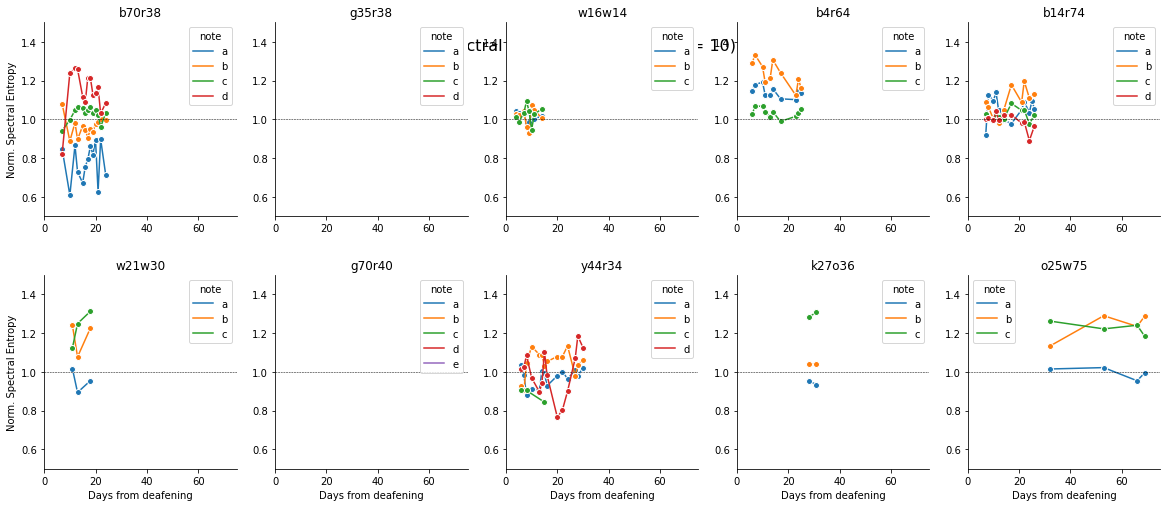

In [9]:
# Normalized spectral entropy
plot_across_days_per_note(df_norm, x='taskSessionDeafening', y='entropyUndirNorm',
                          x_label='Days from deafening',
                          y_label='Norm. Spectral Entropy',
                          title=f"Norm. Spectral Entropy (nb of notes >= {nb_note_crit}) Undir",
                          fig_name='Norm_spectral_entropy_across_days',
                          x_lim=[0, 75], y_lim=[0.5, 1.5],
                          hline=1,
                          view_folder=True,
                          save_fig=False,
                          save_path=save_path
                          )

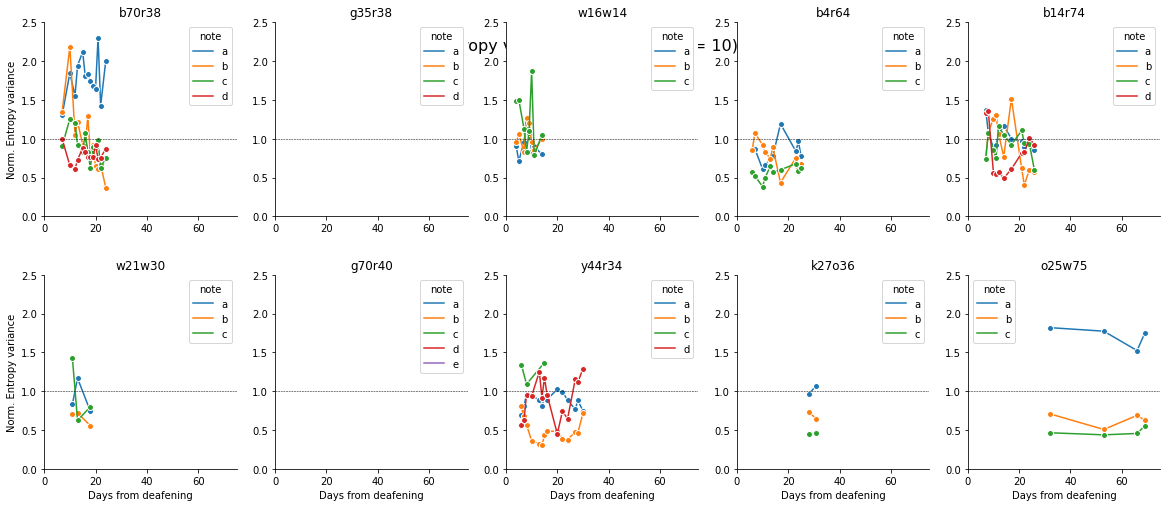

In [10]:
# Normalized ev
plot_across_days_per_note(df_norm, x='taskSessionDeafening', y='entropyVarUndirNorm',
                          x_label='Days from deafening',
                          y_label='Norm. Entropy variance',
                          title=f"Norm. Entropy variance (nb of notes >= {nb_note_crit}) Undir",
                          fig_name='Norm_entropy_variance_across_days',
                          x_lim=[0, 75], y_lim=[0, 2.5],
                          hline=1,
                          view_folder=True,
                          save_fig=False,
                          save_path=save_path
                          )

## Connect paired data
- Colored by bird (set color_by_bird=True)
- Performs independent two-sample t-test since there are data that are non-paired 

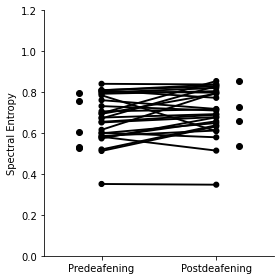

In [11]:
# Entropy
from util.plot import plot_paired_data

plot_paired_data(df_norm, x='taskName', y='entropyUndir',
                 x_label=None, y_label="Spectral Entropy",
                 y_lim=[0, 1.2],
                 fig_size=(4, 4),
                 view_folder=True,
                 fig_name='Spectral_entropy_comparison',
                 color_by_bird=False,
                 save_fig=False,
                 save_path=save_path,
                 fig_ext='.png'
                 )

## Plot song features across day blocks

In [12]:
# Load song database
db = ProjectLoader().load_db()
# Get pre-deafening baseline
query = f"""SELECT syl.birdID, syl.taskName, song.taskSessionPostDeafening, song.block10days, syl.note, syl.entropy, syl.entropyVar AS ev
            FROM individual_syllable syl INNER JOIN song
            ON song.id = syl.songID WHERE syl.context='U' AND syl.taskName='Predeafening'"""
df_pre = db.to_dataframe(query)

## Number of notes from pre-deafening

In [13]:
import pprint
nb_note_pre = df_pre.groupby(['birdID', 'note'])['note'].count().to_dict()
pprint.pprint(nb_note_pre)

{('b14r74', 'a'): 198,
 ('b14r74', 'b'): 181,
 ('b14r74', 'c'): 180,
 ('b14r74', 'd'): 179,
 ('b4r64', 'a'): 480,
 ('b4r64', 'b'): 480,
 ('b4r64', 'c'): 478,
 ('b70r38', 'a'): 66,
 ('b70r38', 'b'): 62,
 ('b70r38', 'c'): 61,
 ('b70r38', 'd'): 58,
 ('g70r40', 'a'): 39,
 ('g70r40', 'b'): 39,
 ('g70r40', 'c'): 39,
 ('g70r40', 'd'): 37,
 ('g70r40', 'e'): 34,
 ('k27o36', 'a'): 119,
 ('k27o36', 'b'): 112,
 ('k27o36', 'c'): 108,
 ('o25w75', 'a'): 147,
 ('o25w75', 'b'): 146,
 ('o25w75', 'c'): 145,
 ('w16w14', 'a'): 673,
 ('w16w14', 'b'): 447,
 ('w16w14', 'c'): 406,
 ('w21w30', 'a'): 644,
 ('w21w30', 'b'): 626,
 ('w21w30', 'c'): 623,
 ('y44r34', 'a'): 314,
 ('y44r34', 'b'): 309,
 ('y44r34', 'c'): 119,
 ('y44r34', 'd'): 228}


## 50/50% random split of the pre-deafening data into template song and pre-deafening song

In [14]:
def split_df(df_pre):
    """
    Randomly split the pre-song data
    """
    # bird_list = df_pre['birdID'].unique()
    df_baseline = pd.DataFrame()  # will be used for template song for normalizing pre & post song
    df_pre_data = pd.DataFrame() # pre-deafening song to be plotted (block 0)

    for (bird, note), _ in nb_note_pre.items():
        # if bird != 'b14r74':  continue
        df_temp = df_pre.loc[(df_pre['birdID'] == bird) & (df_pre['note'] == note)]
        # 50% split 
        df_temp1 = df_temp.sample(frac=0.5, random_state=1)
        df_temp2 = df_temp.drop(df_temp1.index)
        df_baseline = pd.concat([df_baseline, df_temp1], axis=0)  # used for normalization
        df_pre_data = pd.concat([df_pre_data, df_temp2], axis=0)  # used for data plotting (block 0)
        
    df_baseline = df_baseline.groupby(['birdID', 'note', 'block10days'])['entropy', 'ev'].mean().reset_index() # averaged per bird and syllable 
    df_pre_data = df_pre_data.groupby(['birdID', 'note', 'block10days'])['entropy', 'ev'].mean().reset_index() # averaged per bird and syllable 
    return df_baseline, df_pre_data

df_baseline, df_pre_data = split_df(df_pre)

In [15]:
# Get post-deafening data
db = ProjectLoader().load_db()
query = f"""SELECT syl.birdID, syl.taskName, song.taskSessionPostDeafening, song.block10days, syl.note, syl.entropy, syl.entropyVar AS ev
            FROM individual_syllable syl INNER JOIN song
            ON song.id = syl.songID WHERE syl.context='U' AND syl.taskName='Postdeafening'"""
df_post = db.to_dataframe(query)
df_post_data = df_post.groupby(['birdID', 'note', 'block10days'])['entropy', 'ev'].mean().reset_index()  # get the mean entropy & ev per note per block
df_post_data['nb_notes'] = df_post.groupby(['birdID', 'note', 'block10days'])['note'].count().values  # add number of notes column

In [21]:
df_post_data.head()

,birdID,note,block10days,entropy,ev,nb_notes
0,b14r74,a,1,0.661519,0.018273,291
1,b14r74,a,2,0.682901,0.016744,172
2,b14r74,a,3,0.698318,0.014319,324
3,b14r74,b,1,0.633401,0.004493,272
4,b14r74,b,2,0.618947,0.005085,131


## Concatenate pre & post and normalize by division with pre-deafening baseline

In [22]:
df_target = pd.concat([df_pre_data, df_post_data], axis=0)

def get_norm_df(df_target, df_baseline):
    """
    Get a new table that has normalized song features
    """
     
    birds = df_target['birdID'].unique()
    notes = df_target['note'].unique()
    
    df_norm = pd.DataFrame()

    for bird in birds:
#         if bird != 'b14r74': continue
        for note in notes:

            df_temp1 = df_target.query(f"birdID == '{bird}' and note == '{note}'") 
            df_temp2 = df_baseline.query(f"birdID == '{bird}' and note == '{note}'")  # baseline
            if not len(df_temp1) or not len(df_temp2): continue
            # print(bird, note)
            df_temp1['entropy'] /= df_temp2['entropy'].values
            df_temp1['ev'] /= df_temp2['ev'].values
            df_norm = pd.concat([df_norm, df_temp1], axis=0)  # used for normalization
            
    return df_norm.reset_index()

df_norm = get_norm_df(df_target, df_baseline)

## Plot the results across day blocks

UnboundLocalError: local variable 'day_block_label_list' referenced before assignment

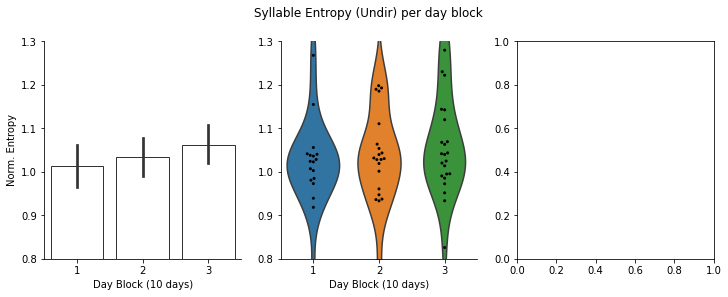

In [20]:
from util.plot import plot_bar_comparison, plot_per_day_block

# Entropy
plot_per_day_block(df_norm, ind_var_name='block10days', dep_var_name='entropy',
                   title=f'Syllable Entropy (Undir) per day block',
                   y_label='Norm. Entropy',
                   y_lim=[0.8, 1.3],
                   post_hoc=True,
                   fig_name='Syllable_entropy_across_day_blocks',
                   save_fig=False, fig_ext='.png'
                   )


# EV
plot_per_day_block(df_norm, ind_var_name='block10days', dep_var_name='ev',
                   title=f'Syllable EV (Undir) per day block',
                   y_label='Norm. EV',
#                    y_lim=[0.5, 1.5],
                   post_hoc=True,
                   fig_name='Syllable_ev_across_day_blocks',
                   save_fig=False, fig_ext='.png'
                   )


## Line plot

- Each line from individual syllables

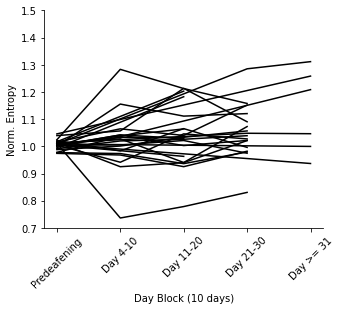

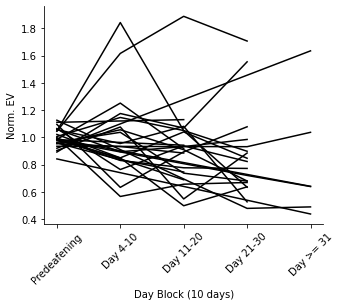

In [26]:
# Entropy
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for bird in df_norm['birdID'].unique():
    df_bird=df_norm.query(f"birdID == '{bird}'")
    for note in df_bird['note'].unique():
        df_note=df_bird.query(f"note == '{note}'")
        plt.plot(df_note['block10days'], df_note['entropy'], 'k')
    
remove_right_top(ax)

ax.set_xlabel('Day Block (10 days)'), ax.set_ylabel('Norm. Entropy')
ax.set_ylim([0.7, 1.5])
xticks = [0, 1, 2, 3, 4]
day_block_label_list = ['Predeafening', 'Day 4-10', 'Day 11-20', 'Day 21-30', 'Day >= 31']
ax.set_xticks(xticks)
ax.set_xticklabels(day_block_label_list, rotation=45)
plt.show()


# EV
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for bird in df_norm['birdID'].unique():
    df_bird=df_norm.query(f"birdID == '{bird}'")
    for note in df_bird['note'].unique():
        df_note=df_bird.query(f"note == '{note}'")
        plt.plot(df_note['block10days'], df_note['ev'], 'k')
    
remove_right_top(ax)

ax.set_xlabel('Day Block (10 days)'), ax.set_ylabel('Norm. EV')
# ax.set_ylim([0.7, 1.5])
xticks = [0, 1, 2, 3, 4]
day_block_label_list = ['Predeafening', 'Day 4-10', 'Day 11-20', 'Day 21-30', 'Day >= 31']
ax.set_xticks(xticks)
ax.set_xticklabels(day_block_label_list, rotation=45)
plt.show()


## Use all pre-deafening songs as a baseline. Normalize by the baseline

- Each dot indicates individual syllables.
- Horizontal dash (=1) indicates pre-deafening mean baseline

In [23]:
# Load song database
db = ProjectLoader().load_db()
# Get pre-deafening baseline
query = f"""SELECT syl.birdID, syl.taskName, song.taskSessionPostDeafening, song.block10days, syl.note, syl.entropy, syl.entropyVar AS ev
            FROM individual_syllable syl INNER JOIN song
            ON song.id = syl.songID WHERE syl.context='U' AND syl.taskName='Predeafening'"""
df_pre = db.to_dataframe(query)
df_pre_data = df_pre.groupby(['birdID', 'note', 'block10days'])['entropy', 'ev'].mean().reset_index()

# Get post-deafening song
query = f"""SELECT syl.birdID, syl.taskName, song.taskSessionPostDeafening, song.block10days, syl.note, syl.entropy, syl.entropyVar AS ev
            FROM individual_syllable syl INNER JOIN song
            ON song.id = syl.songID WHERE syl.context='U' AND syl.taskName='Postdeafening'"""
df_post = db.to_dataframe(query)
df_post_data = df_post.groupby(['birdID', 'note', 'block10days'])['entropy', 'ev'].mean().reset_index()  # get the mean entropy & ev per note per block
df_post_data['nb_notes'] = df_post.groupby(['birdID', 'note', 'block10days'])['note'].count().values  # add number of notes column

# Normalize post-song by the pre-song
df_norm = get_norm_df(df_post_data, df_pre_data)

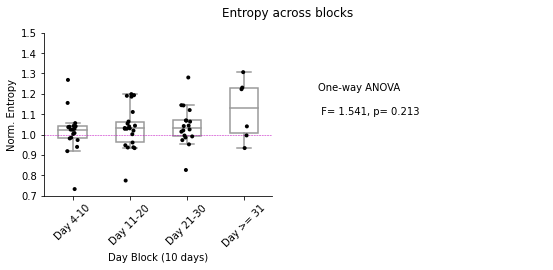

block 1 : t(17)= 0.558, p= 0.292 (one-sample t-test)
block 2 : t(20)= 1.477, p= 0.078 (one-sample t-test)
block 3 : t(17)= 1.859, p= 0.040 (one-sample t-test)
block 4 : t(5)= 1.967, p= 0.053 (one-sample t-test)


In [24]:
# Entropy relative to the baseline (=1)
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
plt.suptitle("Entropy across blocks", y=1, fontsize=12)

# sns.violinplot('block10days', 'entropy', data=df_norm, ax=axes[1], inner=None)
# sns.swarmplot('block10days', 'entropy', data=df_norm, ax=axes[0], color="k", size=4)
sns.stripplot('block10days', 'entropy', data=df_norm, ax=axes[0], color="k", jitter=0.1, size=4)
sns.boxplot('block10days', 'entropy', data=df_norm, ax=axes[0], width=0.5, color='w', showfliers = False)
remove_right_top(axes[0])

axes[0].set_xlabel('Day Block (10 days)'), axes[0].set_ylabel('Norm. Entropy')
axes[0].set_ylim([0.7, 1.5])
day_block_label_list = ['Day 4-10', 'Day 11-20', 'Day 21-30', 'Day >= 31']
axes[0].set_xticklabels(day_block_label_list, rotation=45)
axes[0].set_xticklabels(day_block_label_list, rotation=45)
axes[0].axhline(y=1, color='m', ls='--', lw=0.5)

# Run one-way ANOVA
import scipy.stats as stats
f_val, p_val = stats.f_oneway(
                              df_norm['entropy'][df_norm['block10days'] == 1],
                              df_norm['entropy'][df_norm['block10days'] == 2],
                              df_norm['entropy'][df_norm['block10days'] == 3],
                              df_norm['entropy'][df_norm['block10days'] == 4]
                              )

msg = f"""One-way ANOVA \n\n F={f_val: 0.3f}, p={p_val: 0.3f}"""
axes[1].text(0, 0.5, msg), axes[1].axis('off')
plt.show()

# Run one-sample test for each block relative to the pre-deafening baseline (=1)
import scipy.stats as stats

for block in df_norm['block10days'].unique():
    data = df_norm[df_norm['block10days'] == block]['entropy']
    statistics = stats.ttest_1samp(a=data, popmean=1, alternative='greater')
    msg = f"""block {block} : t({len(data.dropna())-1})={statistics.statistic: 0.3f}, p={statistics.pvalue: 0.3f} (one-sample t-test)"""
    print(msg)

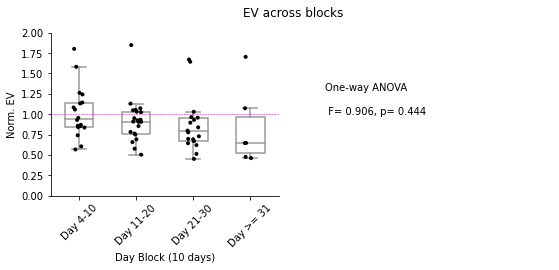

block 1 : t(17)= 0.257, p= 0.600 (one-sample t-test)
block 2 : t(20)=-1.369, p= 0.093 (one-sample t-test)
block 3 : t(17)=-1.788, p= 0.046 (one-sample t-test)
block 4 : t(5)=-0.850, p= 0.217 (one-sample t-test)


In [25]:
# Entropy relative to the baseline (=1)
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
plt.suptitle("EV across blocks", y=1, fontsize=12)
sns.stripplot('block10days', 'ev', data=df_norm, ax=axes[0], color="k", jitter=0.1, size=4)
sns.boxplot('block10days', 'ev', data=df_norm, ax=axes[0], width=0.5, color='w', showfliers = False)
remove_right_top(axes[0])

axes[0].set_xlabel('Day Block (10 days)'), axes[0].set_ylabel('Norm. EV')
axes[0].set_ylim([0, 2])
day_block_label_list = ['Day 4-10', 'Day 11-20', 'Day 21-30', 'Day >= 31']
axes[0].set_xticklabels(day_block_label_list, rotation=45)
axes[0].set_xticklabels(day_block_label_list, rotation=45)
axes[0].axhline(y=1, color='m', ls='--', lw=0.5)

# Run one-way ANOVA
import scipy.stats as stats
f_val, p_val = stats.f_oneway(
                              df_norm['ev'][df_norm['block10days'] == 1],
                              df_norm['ev'][df_norm['block10days'] == 2],
                              df_norm['ev'][df_norm['block10days'] == 3],
                              df_norm['ev'][df_norm['block10days'] == 4],
                              )

msg = f"""One-way ANOVA \n\n F={f_val: 0.3f}, p={p_val: 0.3f}"""
axes[1].text(0, 0.5, msg), axes[1].axis('off')
plt.show()

# Run one-sample test for each block relative to the pre-deafening baseline (=1)
import scipy.stats as stats

for block in df_norm['block10days'].unique():
    data = df_norm[df_norm['block10days'] == block]['ev']
    statistics = stats.ttest_1samp(a=data, popmean=1, alternative='less')
    msg = f"""block {block} : t({len(data.dropna())-1})={statistics.statistic: 0.3f}, p={statistics.pvalue: 0.3f} (one-sample t-test)"""
    print(msg)

## Combine block 3 & 4

- Combine values from 3 and 4th block into a single block (Day >= 21)
- Compare the values to the pre-deafening baseline (=1) using one-sample test (parameteric & non-parametric).
- Performs bonferroni correction for each block comparison (alpha = 0.05)

### Entropy

NameError: name 'ax' is not defined

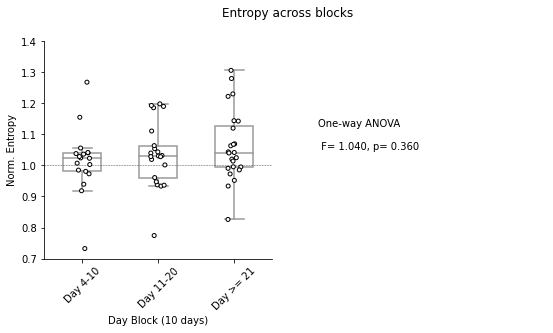

In [26]:
save_fig = False

# Entropy relative to the baseline (=1)
df_norm['block10days'].replace(4, 3, inplace=True)  # replace empty values with nans to prevent an error

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
plt.suptitle("Entropy across blocks", y=1, fontsize=12)
sns.stripplot('block10days', 'entropy', data=df_norm, ax=axes[0], 
              color='w', edgecolor='k', linewidth=1,
              jitter=0.1, size=4)
sns.boxplot('block10days', 'entropy', data=df_norm, ax=axes[0], width=0.5, color='w', showfliers = False)
remove_right_top(axes[0])

axes[0].set_xlabel('Day Block (10 days)'), axes[0].set_ylabel('Norm. Entropy')
axes[0].set_ylim([0.7, 1.4])
day_block_label_list = ['Day 4-10', 'Day 11-20', 'Day >= 21']
axes[0].set_xticklabels(day_block_label_list, rotation=45)
axes[0].set_xticklabels(day_block_label_list, rotation=45)
axes[0].axhline(y=1, color='m', ls='--', lw=0.5)

# Run one-way ANOVA
import scipy.stats as stats
f_val, p_val = stats.f_oneway(
                              df_norm['entropy'][df_norm['block10days'] == 1],
                              df_norm['entropy'][df_norm['block10days'] == 2],
                              df_norm['entropy'][df_norm['block10days'] == 3],
                              )

msg = f"""One-way ANOVA \n\n F={f_val: 0.3f}, p={p_val: 0.3f}"""
axes[1].text(0, 0.5, msg), axes[1].axis('off')

# Run one-sample test for each block relative to the pre-deafening baseline (=1)
import scipy.stats as stats
from scipy.stats import wilcoxon
hyp_median = 1  # hypothesized median (pre-deafening baseline)
corrected_p = 0.05 / len(df_norm['block10days'].unique()) # p-value for Bonferroni multiple correction

msg_to_show = ''

for block in df_norm['block10days'].unique():
    data = df_norm[df_norm['block10days'] == block]['entropy']
    # t-test
    # statistics = stats.ttest_1samp(a=data, popmean=1, alternative='greater')
    # msg = f"""block {block} : t({len(data.dropna())-1})={statistics.statistic: 0.3f}, p={statistics.pvalue: 0.3f} (one-sample t-test)"""
    
    # Wilcoxon signed rank test
    z, p = wilcoxon(data-hyp_median, alternative='greater')
    sig = '*' if p < corrected_p else ''
    msg = f"""block {block} : z={z: 0.3f}, p={p: 0.4f} (One-sample Wilcoxon Signed Rank Test) {sig} \n\n""" 
    msg_to_show += msg

axes[1].text(0.9, 0.1, msg_to_show, transform=ax.transAxes)
fig.tight_layout()
if save_fig:
    save.save_fig(fig, save_path, 'EntropyAcrossBlocks', view_folder=True, fig_ext='.pdf')
else:
    plt.show()

In [29]:
df_norm.to_csv('norm_entropy.csv')

### EV

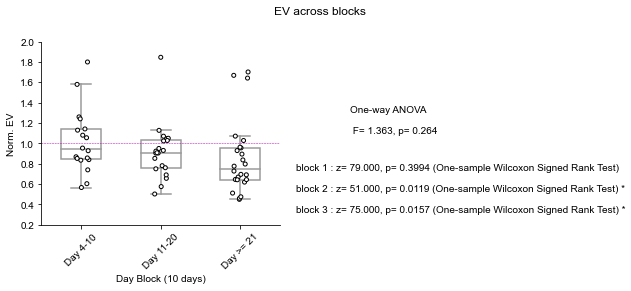

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
plt.suptitle("EV across blocks", y=1, fontsize=12)
sns.stripplot('block10days', 'ev', data=df_norm, ax=axes[0], 
              color='w', edgecolor='k', linewidth=1,
              jitter=0.1, size=4)
sns.boxplot('block10days', 'ev', data=df_norm, ax=axes[0], width=0.5, color='w', showfliers = False)
remove_right_top(axes[0])

axes[0].set_xlabel('Day Block (10 days)'), axes[0].set_ylabel('Norm. EV')
axes[0].set_ylim([0.2, 2])
day_block_label_list = ['Day 4-10', 'Day 11-20', 'Day >= 21']
axes[0].set_xticklabels(day_block_label_list, rotation=45)
axes[0].set_xticklabels(day_block_label_list, rotation=45)
axes[0].axhline(y=1, color='m', ls='--', lw=0.5)

# Run one-way ANOVA
import scipy.stats as stats
f_val, p_val = stats.f_oneway(
                              df_norm['ev'][df_norm['block10days'] == 1],
                              df_norm['ev'][df_norm['block10days'] == 2],
                              df_norm['ev'][df_norm['block10days'] == 3],
                              )

msg = f"""One-way ANOVA \n\n F={f_val: 0.3f}, p={p_val: 0.3f}"""
axes[1].text(0, 0.5, msg), axes[1].axis('off')

# Run one-sample test for each block relative to the pre-deafening baseline (=1)
import scipy.stats as stats
from scipy.stats import wilcoxon
hyp_median = 1  # hypothesized median (pre-deafening baseline)
corrected_p = 0.05 / len(df_norm['block10days'].unique()) # p-value for Bonferroni multiple correction

msg_to_show = ''

for block in df_norm['block10days'].unique():
    data = df_norm[df_norm['block10days'] == block]['ev']
    # t-test
    # statistics = stats.ttest_1samp(a=data, popmean=1, alternative='less')
    # msg = f"""block {block} : t({len(data.dropna())-1})={statistics.statistic: 0.3f}, p={statistics.pvalue: 0.3f} (one-sample t-test)"""
    
    # Wilcoxon signed rank test
    z, p = wilcoxon(data-hyp_median, alternative='less')
    sig = '*' if p < corrected_p else ''
    msg = f"""block {block} : z={z: 0.3f}, p={p: 0.4f} (One-sample Wilcoxon Signed Rank Test) {sig} \n\n""" 
    msg_to_show += msg

axes[1].text(0.9, 0.1, msg_to_show, transform=ax.transAxes)
fig.tight_layout()

if save_fig:
    save.save_fig(fig, save_path, 'EVAcrossBlocks', view_folder=True, fig_ext='.pdf')
else:
    plt.show()

In [37]:
df_norm.sort_values(by='ev', ascending=False).head(20)

,index,birdID,note,block10days,entropy,ev,nb_notes
22,22,b70r38,a,2,0.774146,1.846823,567
24,24,b70r38,b,1,0.980758,1.800721,58
39,43,o25w75,a,3,0.995482,1.702572,98
23,23,b70r38,a,3,0.825967,1.669381,181
59,63,y44r34,c,3,1.013860,1.642339,24
21,21,b70r38,a,1,0.732308,1.580507,59
46,50,w16w14,c,1,1.038032,1.260868,284
57,61,y44r34,c,1,0.918384,1.241666,99
0,0,b14r74,a,1,1.007141,1.142450,291
9,9,b14r74,d,1,1.002779,1.130527,269
